# Final Project Submission

* **Student name**: Sara Robinson
* **Student pace**: *self paced*/part time/full time
* **Scheduled project review date/time**: 9/7/2021 11:00
* **Instructor name**: Jeff Herman
* **Blog post URL**: https://medium.com/@sara.robinson27/classifying-a-tweets-sentiment-based-on-its-content-9835069aa2b3
* **Notebook**: 3/4

## Introduction

The purpose of this project is to build a model that can rate the sentiment of a tweet based on its content. The data is from CrowdFlower and contains over 9000 tweets about Apple and Google products rated by humans as either postive, negative, or neither.

This is the third notebook for the Phase 4 Final Project. This notebook follows data exploration and continues into baseline modeling of the data.


## Import Libraries

In the following cells I import the necessary libraries for this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

## Load and Inspect Data

In the following cells I load the cleaned dataset that we explored in the previous notebook and check it to make sure everything is ready to be modeled.

In [2]:
df = pd.read_csv('CleanedDF.csv') #Read in dataset
df.head() #Checking first 5 rows

,Tweet,Product,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean,Clean Character Count,Clean Tokens,Clean Token Count,Tweet Tokens,Tweet Token Count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"['#RISE_Austin', '#SXSW']",2,i have a g iphone after hrs tweeting at risea...,104,"['i', 'have', 'g', 'iphone', 'after', 'hrs', '...",16,"['.', '@wesley83', 'I', 'have', 'a', '3G', 'iP...",29
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,['#SXSW'],1,know about awesome ipadiphone app that youll ...,112,"['know', 'about', 'awesome', 'ipadiphone', 'ap...",15,"['@jessedee', 'Know', 'about', '@fludapp', '?'...",26
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"['#iPad', '#SXSW']",2,can not wait for ipad also they should sale t...,61,"['can', 'not', 'wait', 'ipad', 'also', 'they',...",11,"['@swonderlin', 'Can', 'not', 'wait', 'for', '...",17
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,['#sxsw'],1,i hope this years festival isnt as crashy as ...,71,"['i', 'hope', 'years', 'festival', 'isnt', 'as...",12,"['@sxsw', 'I', 'hope', 'this', ""year's"", 'fest...",16
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,['#SXSW'],1,great stuff on fri sxsw marissa mayer google ...,103,"['great', 'stuff', 'fri', 'sxsw', 'marissa', '...",14,"['@sxtxstate', 'great', 'stuff', 'on', 'Fri', ...",27


In [3]:
df.info() #Checking to make sure everything loaded correctly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9070 entries, 0 to 9069
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tweet                  9070 non-null   object
 1   Product                9070 non-null   object
 2   Emotion                9070 non-null   object
 3   Brand                  9070 non-null   object
 4   Tweet Character Count  9070 non-null   int64 
 5   Hashtag                9070 non-null   object
 6   Hashtag Count          9070 non-null   int64 
 7   Clean                  9070 non-null   object
 8   Clean Character Count  9070 non-null   int64 
 9   Clean Tokens           9070 non-null   object
 10  Clean Token Count      9070 non-null   int64 
 11  Tweet Tokens           9070 non-null   object
 12  Tweet Token Count      9070 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 921.3+ KB


Everything is looking good! Let's create a new dataframe with just the cleaned tokens column and emotions column. We'll also convert the clean tokens column from a list of strings as a string to just a list of strings again before we make the new dataframe. We're doing this because if you look above you can see that each token is in quotes which we don't want, so instead of going through and cleaning it all again we can quickly use one line of code to change it.

In [4]:
df['Clean Tokens'] = df['Clean Tokens'].map(ast.literal_eval) #converting list of strings as string to list of strings

data = df[['Clean Tokens', 'Emotion']] #Creating dataframe to use when modeling

data.head() #Checking new dataframe

,Clean Tokens,Emotion
0,"[i, have, g, iphone, after, hrs, tweeting, ris...",Negative
1,"[know, about, awesome, ipadiphone, app, youll,...",Positive
2,"[can, not, wait, ipad, also, they, should, sal...",Positive
3,"[i, hope, years, festival, isnt, as, crashy, a...",Negative
4,"[great, stuff, fri, sxsw, marissa, mayer, goog...",Positive


Great! Now we're going to move on to preparing the data to be modeled.

# Preparing to Model

Before we can model the data, we need to perform a train test split and split the data into training and test sets. I am going to quickly put all of my functions for modeling above all of this to keep them together.

In [5]:
def passthrough(doc): #Function to passthrough our pipelines
    return doc #returns same

def confmat_and_classrep(estimator, X, y, labels, set_name): #Function that prints confusion matrix and class report
    predictions = estimator.predict(X) #predicts from estimators
    print(f'Classification Report for {set_name} Set') #print classification report name
    print(classification_report(y, predictions, target_names = labels)) #print classification report numbers
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5)) #Making subplots for each matrix
    matrix = plot_confusion_matrix(estimator, X, y, display_labels = labels, cmap = plt.cm.viridis, 
                                  xticks_rotation = 70, values_format = 'd', ax = axes[0]) #plot non-normal matrix
    matrix.ax_.set_title(f'{set_name} Set Confusion Matrix, \n without Normalization') #setting title of non-normal
    matrix = plot_confusion_matrix(estimator, X, y, display_labels = labels, cmap = plt.cm.viridis, 
                                  xticks_rotation = 70, normalize = 'true', ax = axes[1]) #plot normal matrix
    matrix.ax_.set_title(f'{set_name} Set Confusion Matrix, \n with Normalization') #setting title of normal matrix
    plt.subplots_adjust(wspace = 0.5) #Adding space between graphs
    plt.show() #Showing matrix
    
    print(f"Cohen's Kappa Score for {set_name} Set:") #Setting title for cohen's kappa score
    print(round(cohen_kappa_score(y, predictions), 3)) #printing cohen's kappa score
    
    print(f"Matthew's Correlation Coefficient for {set_name} Set:") #Setting title for matt's corr coef
    print(round(matthews_corrcoef(y, predictions), 3)) #printing matt's corr coef
    
def pr_curves(y_test_multi, y_hat_test_multi, classes): #Function that prints precision recall curves
    precision = dict() #creating dict of precision scores
    recall = dict() #creating dict of recall scores
    pr_auc = dict() #creating dict of auc
    for i in range(3): #for loop
        precision[i], recall[i], _ = precision_recall_curve(y_test_multi[:, i], y_hat_test_multi[:, i]) #calling
        pr_auc[i] = auc(recall[i], precision[i]) #setting
    
    plt.figure()
    lw = 2
    colors = ['red', 'blue', 'green']
    
    for i, class_ in enumerate(classes):
        plt.plot(recall[i], precision[i], color = colors[i], lw = lw, 
                 label = f'{classes[i]}, PR Curve AUC: {round(pr_auc[i], 2)}')
    
    plt.plot([0, 1], [1, 0], 'k--') #setting plot with label
    plt.xlim([0.0, 1.0]) #setting limits of x
    plt.ylim([0.0, 1.05]) #setting limits of y
    plt.xlabel('Recall') #labeling x
    plt.ylabel('Precision') #labeling y
    plt.title('Precision Recall Curve') #setting title
    plt.legend(loc="lower left") #setting legend
    plt.show() #Showing graph
        
def roc_curves(y_test_multi, y_hat_test_multi, classes): #Function that prints roc curves
    fpr = dict() #creating dict of fpr
    tpr = dict() #creating dict of tpr
    roc_auc = dict() #Creating dict of auc
    for i in range(3): #for loop
        fpr[i], tpr[i], _ = roc_curve(y_test_multi[:, i], y_hat_test_multi[:, i]) #calling
        roc_auc[i] = auc(fpr[i], tpr[i]) #setting
    
    plt.figure()
    lw = 2
    colors = ['deeppink', 'royalblue', 'lawngreen']
    
    for i, class_ in enumerate(classes): #for loop to create singular graphs
        plt.plot(fpr[i], tpr[i], color = colors[i], lw = lw, 
                 label = f'{classes[i]}, ROC Curve AUC: {round(roc_auc[i], 2)}') #setting plot with label
        
    plt.plot([0, 1], [0, 1], 'k--') #setting plot with label
    plt.xlim([0.0, 1.0]) #setting limits of x
    plt.ylim([0.0, 1.05]) #setting limits of y
    plt.xlabel('False Positive Rate') #labeling x
    plt.ylabel('True Positive Rate') #labeling y
    plt.title('Receiver Operating Characteristic Curve') #setting title
    plt.legend(loc="lower right") #setting legend
    plt.show() #showing graph

In [6]:
X = data['Clean Tokens'] #Setting X
y = data['Emotion'] #Setting y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 43, stratify = data['Emotion']) #Splitting data

display(X_train.shape) #Checking shape of X_train
display(y_train.shape) #Checking shape of y_train
display(X_test.shape) #Checking shape of X_test
display(y_test.shape) #Checking shape of y_test

(6802,)

(6802,)

(2268,)

(2268,)

Great! We're all set up and ready to start modeling.


# Baseline Modeling

Things might get a little messy here because I want to use both the Count Vectorizer and TF-IDF Vectorizer so I can compare the two on each model I run to see which performs best. Here are the baseline models I would like to run:

* Logistic Regression
* Multinomial Naive Bayes
* K Nearest Neighbors
* Random Forest
* Decision Tree
* AdaBoost

That means we'll have 12 baseline models to look at since we'll be using two vectorizers for each. For now, we won't be changing any parameters within any model. As I go through I'll be creating a new dataframe that will contain the accuracy scores, precision scores, recall scores, F1 scores, Cohen's Kappa scores, Matthew's Correlation Coefficients,  precision recall curve auc scores, and receiver operating characteristic auc scores. This way I can determine which models performed best, if any, and which to tune. To distinguish the names of models, the baseline models will not include numbers in their names - just the name and the vectorizer used. When I start tuning I will number the models. Let's get going!

In [7]:
basescores_df = pd.DataFrame(columns = ['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 
                                        'F1 Score', "Cohen's Kappa Score", "Matthew's Correlation Coefficient", 
                                        'Neg PRC AUC Score', 'Neu PRC AUC Score', 'Pos PRC AUC Score', 
                                        'Neg ROC AUC Score', 'Neu ROC AUC Score', 'Pos ROC AUC Score'], 
                         index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
basescores_df.head() #Checking to make sure df was created

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Logistic Regression

We'll start by building a logistic regression model using the count vectorizer. We'll go through and build and evaluate the model, add the pertinent information to our new scores dataframe, then we'll start again and build another one using the tf-idf vectorizer.

### Logistic Regression using Count Vectorizer

In [8]:
le = LabelEncoder() #Instantiating Label Encoder
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression()), 
]) #Creating Logistic Regression pipeline with count vectorizer

LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', LogisticRegression())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.98      0.79      0.87       427
     Neutral       0.90      0.97      0.93      4148
    Positive       0.93      0.84      0.88      2227

    accuracy                           0.91      6802
   macro avg       0.93      0.86      0.89      6802
weighted avg       0.91      0.91      0.91      6802



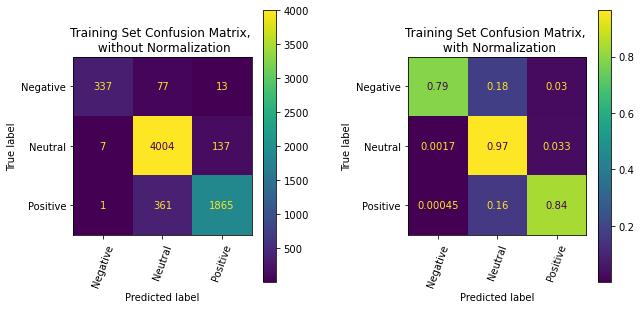

Cohen's Kappa Score for Training Set:
0.825
Matthew's Correlation Coefficient for Training Set:
0.828


In [9]:
confmat_and_classrep(LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.55      0.29      0.38       142
     Neutral       0.73      0.82      0.77      1383
    Positive       0.62      0.54      0.57       743

    accuracy                           0.69      2268
   macro avg       0.63      0.55      0.58      2268
weighted avg       0.68      0.69      0.68      2268



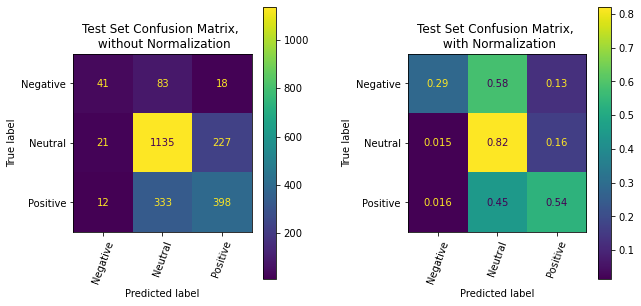

Cohen's Kappa Score for Test Set:
0.373
Matthew's Correlation Coefficient for Test Set:
0.377


In [10]:
confmat_and_classrep(LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR CV Model

The accuracy for the test set is 69% while it is 91% for the training set, this 22% difference tells us that the model is overfit on the training data. An accuracy of 69% is much better than the 33% that random guessing would give us though. We need to keep in mind that we haven't balanced our data yet either - neutral rated tweets make up a significant amount of our data; much more than both positive and negative combined. With this in mind, it makes sense that recall for neutral is 0.82, while recall for positive is 0.54 (the second most emotionally rated tweets are positive), followed with negative recall at 0.29.

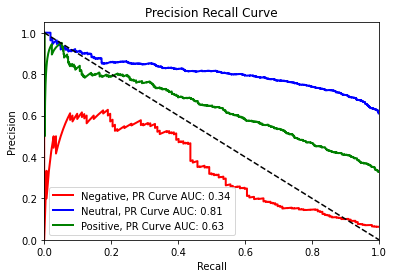

In [11]:
lb = LabelBinarizer() #Instantiating Label Binarizer
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

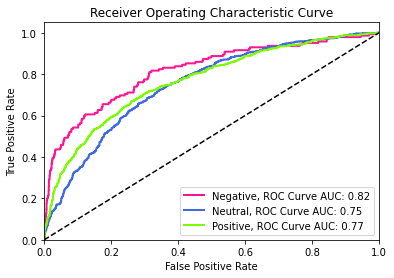

In [12]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [13]:
basescores_df.loc['1'] = pd.Series({'Model Name': 'LogRegCV', 'Accuracy Score': 0.69, 'Precision Score': 0.63, 
                                    'Recall Score': 0.55, 'F1 Score': 0.58, "Cohen's Kappa Score": 0.373, 
                                    "Matthew's Correlation Coefficient": 0.377, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.81, 'Pos PRC AUC Score': 0.63, 'Neg ROC AUC Score': 0.82, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info
basescores_df.head() #Checking head of baseline scores df

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We've officially finished modeling and evaluating our first model! Our baseline scores df is looking good so far as well. Let's move on and do a logistic regression model using the tf-idf vectorizer!

### Logistic Regression using TF-IDF Vectorizer

In [14]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression()), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', LogisticRegression())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.93      0.20      0.32       427
     Neutral       0.79      0.96      0.87      4148
    Positive       0.86      0.65      0.74      2227

    accuracy                           0.81      6802
   macro avg       0.86      0.60      0.64      6802
weighted avg       0.82      0.81      0.79      6802



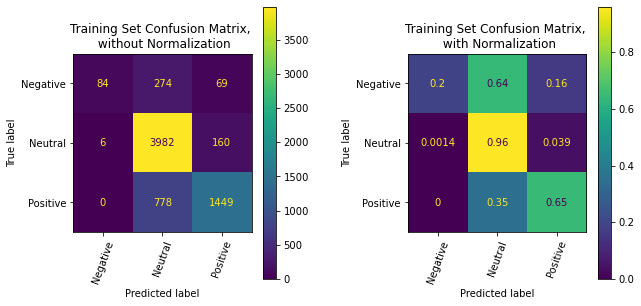

Cohen's Kappa Score for Training Set:
0.595
Matthew's Correlation Coefficient for Training Set:
0.618


In [15]:
confmat_and_classrep(LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.56      0.07      0.12       142
     Neutral       0.71      0.88      0.79      1383
    Positive       0.66      0.47      0.55       743

    accuracy                           0.70      2268
   macro avg       0.64      0.47      0.49      2268
weighted avg       0.68      0.70      0.67      2268



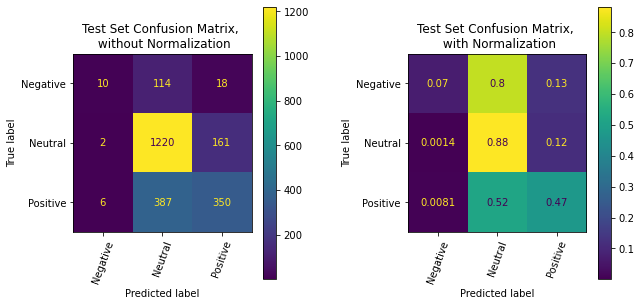

Cohen's Kappa Score for Test Set:
0.341
Matthew's Correlation Coefficient for Test Set:
0.359


In [16]:
confmat_and_classrep(LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

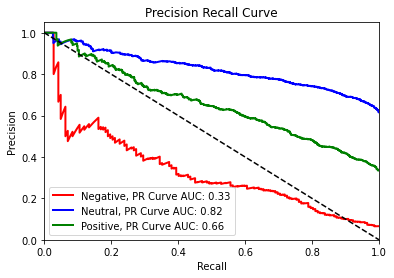

In [17]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

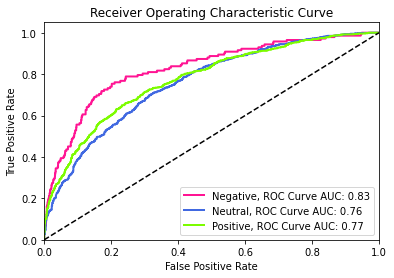

In [18]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [19]:
basescores_df.loc['2'] = pd.Series({'Model Name': 'LogRegTF', 'Accuracy Score': 0.70, 'Precision Score': 0.64, 
                                    'Recall Score': 0.47, 'F1 Score': 0.49, "Cohen's Kappa Score": 0.341, 
                                    "Matthew's Correlation Coefficient": 0.359, 'Neg PRC AUC Score': 0.33, 
                                    'Neu PRC AUC Score': 0.82, 'Pos PRC AUC Score': 0.66, 'Neg ROC AUC Score': 0.83, 
                                    'Neu ROC AUC Score': 0.76, 'Pos ROC AUC Score': 0.77}) #Inputting info
basescores_df.head() #Checking head of baseline scores df

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
2,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our numbers changed slightly between vectorizers which is something to note. Let's move on to the next model!

## Multinomial Naive Bayes

Here we're going to do the same thing as above. Built out two models using two different vectorizers, then add the scores to our baseline scores dataframe.

### Multinomial Naive Bayes using Count Vectorizer

In [20]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB()), 
]) #Creating multinomial naive bayes pipeline with count vectorizer

MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', MultinomialNB())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.91      0.46      0.61       427
     Neutral       0.85      0.91      0.88      4148
    Positive       0.79      0.76      0.77      2227

    accuracy                           0.83      6802
   macro avg       0.85      0.71      0.75      6802
weighted avg       0.83      0.83      0.83      6802



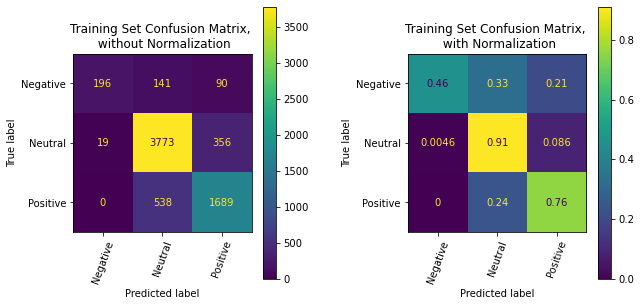

Cohen's Kappa Score for Training Set:
0.661
Matthew's Correlation Coefficient for Training Set:
0.664


In [21]:
confmat_and_classrep(MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.68      0.18      0.29       142
     Neutral       0.73      0.81      0.76      1383
    Positive       0.58      0.54      0.56       743

    accuracy                           0.68      2268
   macro avg       0.66      0.51      0.54      2268
weighted avg       0.68      0.68      0.67      2268



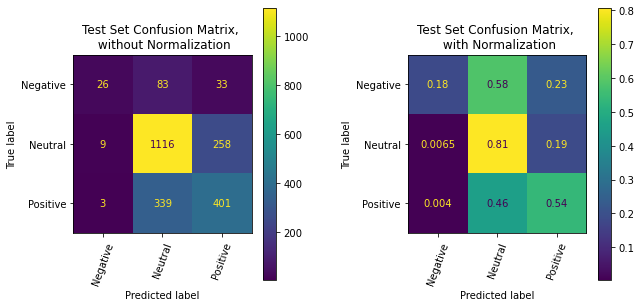

Cohen's Kappa Score for Test Set:
0.342
Matthew's Correlation Coefficient for Test Set:
0.345


In [22]:
confmat_and_classrep(MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB CV Model

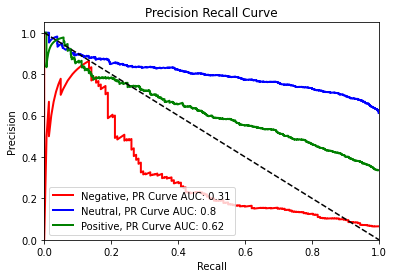

In [23]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

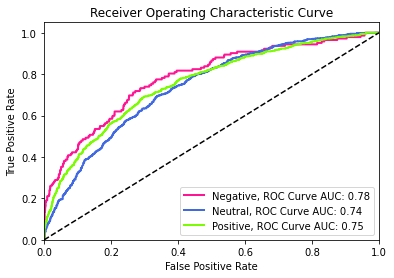

In [24]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [25]:
basescores_df.loc['3'] = pd.Series({'Model Name': 'MNBCV', 'Accuracy Score': 0.68, 'Precision Score': 0.66, 
                                    'Recall Score': 0.51, 'F1 Score': 0.54, "Cohen's Kappa Score": 0.342, 
                                    "Matthew's Correlation Coefficient": 0.345, 'Neg PRC AUC Score': 0.31, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.62, 'Neg ROC AUC Score': 0.78, 
                                    'Neu ROC AUC Score': 0.74, 'Pos ROC AUC Score': 0.75}) #Inputting info
basescores_df.head() #Checking head of baseline scores df

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
2,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
3,MNBCV,0.68,0.66,0.51,0.54,0.342,0.345,0.31,0.8,0.62,0.78,0.74,0.75
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Multinomial Bayes using TF-IDF Vectorizer

In [26]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

MNBpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB()), 
]) #Creating multinomial naive bayes pipeline with tfidf vectorizer

MNBpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', MultinomialNB())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.88      0.02      0.03       427
     Neutral       0.71      0.99      0.83      4148
    Positive       0.90      0.42      0.58      2227

    accuracy                           0.74      6802
   macro avg       0.83      0.48      0.48      6802
weighted avg       0.78      0.74      0.69      6802



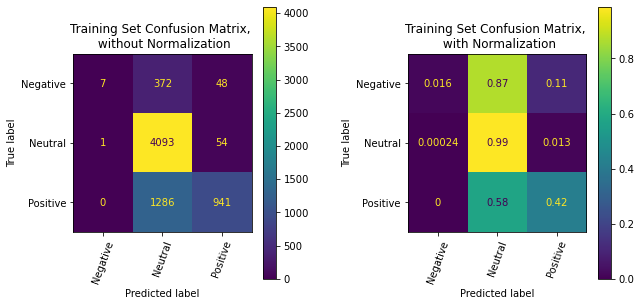

Cohen's Kappa Score for Training Set:
0.404
Matthew's Correlation Coefficient for Training Set:
0.476


In [27]:
confmat_and_classrep(MNBpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       1.00      0.02      0.04       142
     Neutral       0.65      0.97      0.78      1383
    Positive       0.76      0.20      0.32       743

    accuracy                           0.66      2268
   macro avg       0.80      0.40      0.38      2268
weighted avg       0.71      0.66      0.58      2268



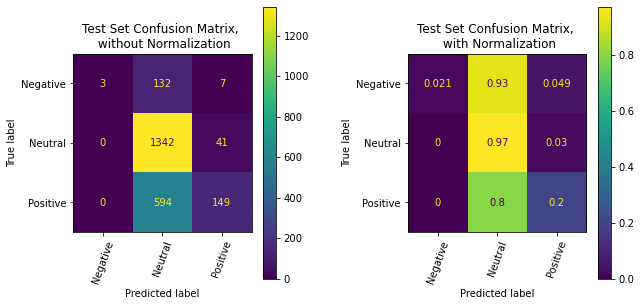

Cohen's Kappa Score for Test Set:
0.179
Matthew's Correlation Coefficient for Test Set:
0.257


In [28]:
confmat_and_classrep(MNBpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB TF model

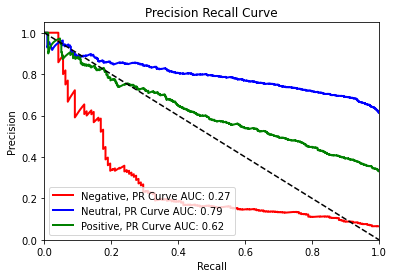

In [29]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = MNBpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

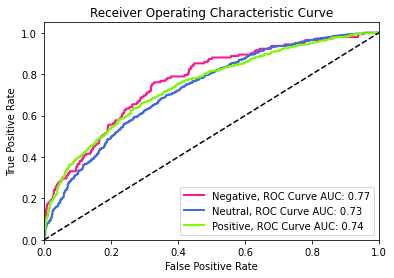

In [30]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [31]:
basescores_df.loc['4'] = pd.Series({'Model Name': 'MNBTF', 'Accuracy Score': 0.66, 'Precision Score': 0.80, 
                                    'Recall Score': 0.40, 'F1 Score': 0.38, "Cohen's Kappa Score": 0.179, 
                                    "Matthew's Correlation Coefficient": 0.257, 'Neg PRC AUC Score': 0.27, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.62, 'Neg ROC AUC Score': 0.77, 
                                    'Neu ROC AUC Score': 0.73, 'Pos ROC AUC Score': 0.74}) #Inputting info
basescores_df.head() #Checking head of baseline scores df

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
2,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
3,MNBCV,0.68,0.66,0.51,0.54,0.342,0.345,0.31,0.8,0.62,0.78,0.74,0.75
4,MNBTF,0.66,0.8,0.4,0.38,0.179,0.257,0.27,0.79,0.62,0.77,0.73,0.74
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At this point, I'm moving along and barring any complications or erronious/interesting outputs I don't think I need to be commenting on everything. To make this a little bit faster I'm just going to zoom through each model now and make some comments after all fourteen models have been built and evaluated.

## K Nearest Neighbors

### K Nearest Neighbors using Count Vectorizer

In [32]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

KNNpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', KNeighborsClassifier()), 
]) #Creating k nearest neighbors pipeline with count vectorizer

KNNpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', KNeighborsClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.47      0.27      0.34       427
     Neutral       0.71      0.95      0.81      4148
    Positive       0.81      0.38      0.52      2227

    accuracy                           0.72      6802
   macro avg       0.66      0.53      0.56      6802
weighted avg       0.73      0.72      0.69      6802



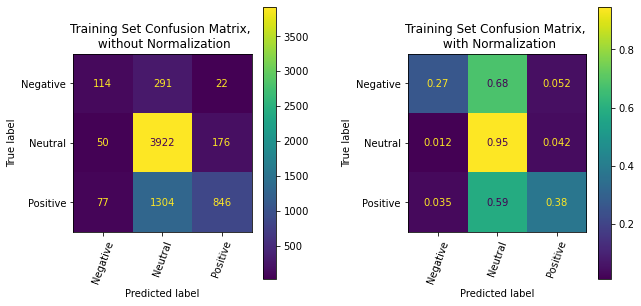

Cohen's Kappa Score for Training Set:
0.377
Matthew's Correlation Coefficient for Training Set:
0.421


In [33]:
confmat_and_classrep(KNNpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training KNN CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.20      0.10      0.13       142
     Neutral       0.65      0.90      0.75      1383
    Positive       0.57      0.21      0.31       743

    accuracy                           0.63      2268
   macro avg       0.47      0.40      0.40      2268
weighted avg       0.60      0.63      0.57      2268



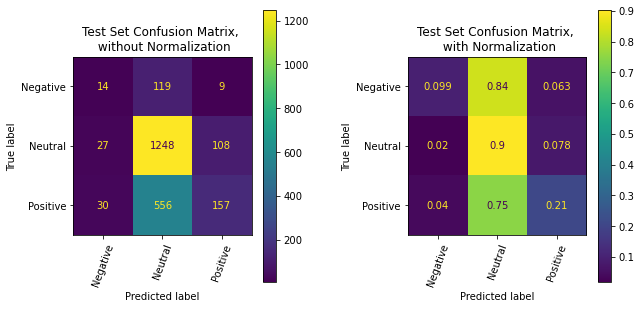

Cohen's Kappa Score for Test Set:
0.152
Matthew's Correlation Coefficient for Test Set:
0.181


In [34]:
confmat_and_classrep(KNNpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test KNN CV model

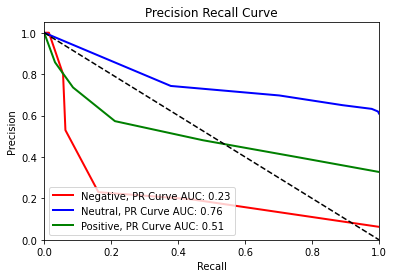

In [35]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = KNNpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

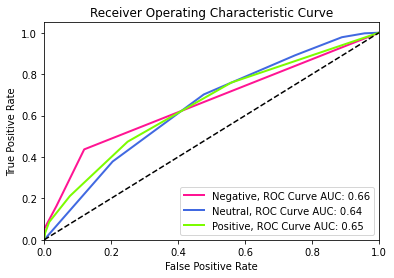

In [36]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [37]:
basescores_df.loc['5'] = pd.Series({'Model Name': 'KNNCV', 'Accuracy Score': 0.63, 'Precision Score': 0.47, 
                                    'Recall Score': 0.40, 'F1 Score': 0.40, "Cohen's Kappa Score": 0.152, 
                                    "Matthew's Correlation Coefficient": 0.181, 'Neg PRC AUC Score': 0.23, 
                                    'Neu PRC AUC Score': 0.76, 'Pos PRC AUC Score': 0.51, 'Neg ROC AUC Score': 0.66, 
                                    'Neu ROC AUC Score': 0.64, 'Pos ROC AUC Score': 0.65}) #Inputting info
basescores_df.head() #Checking head of baseline scores df

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
2,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
3,MNBCV,0.68,0.66,0.51,0.54,0.342,0.345,0.31,0.8,0.62,0.78,0.74,0.75
4,MNBTF,0.66,0.8,0.4,0.38,0.179,0.257,0.27,0.79,0.62,0.77,0.73,0.74
5,KNNCV,0.63,0.47,0.4,0.4,0.152,0.181,0.23,0.76,0.51,0.66,0.64,0.65


### K Nearest Neighbors using TF-IDF Vectorizer

In [38]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

KNNpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', KNeighborsClassifier()), 
]) #Creating k nearest neighbors pipeline with tfidf vectorizer

KNNpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', KNeighborsClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.75      0.30      0.43       427
     Neutral       0.72      0.95      0.82      4148
    Positive       0.83      0.43      0.56      2227

    accuracy                           0.74      6802
   macro avg       0.77      0.56      0.60      6802
weighted avg       0.76      0.74      0.71      6802



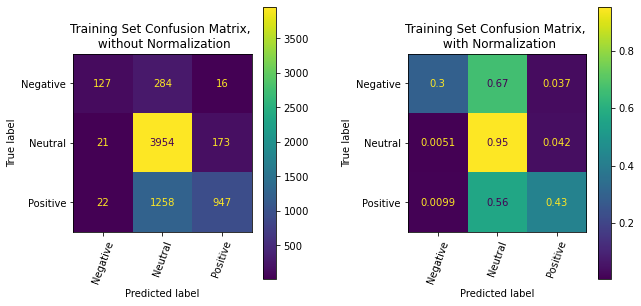

Cohen's Kappa Score for Training Set:
0.422
Matthew's Correlation Coefficient for Training Set:
0.469


In [39]:
confmat_and_classrep(KNNpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training KNN TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.43      0.16      0.23       142
     Neutral       0.66      0.88      0.76      1383
    Positive       0.57      0.28      0.38       743

    accuracy                           0.64      2268
   macro avg       0.55      0.44      0.46      2268
weighted avg       0.62      0.64      0.60      2268



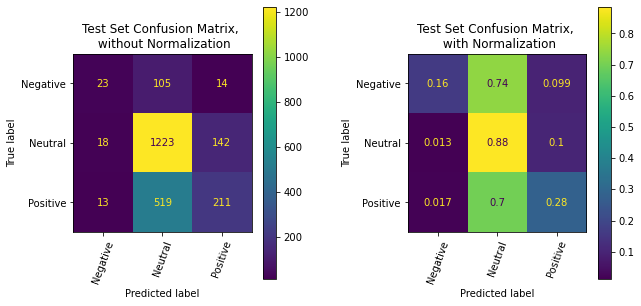

Cohen's Kappa Score for Test Set:
0.203
Matthew's Correlation Coefficient for Test Set:
0.228


In [40]:
confmat_and_classrep(KNNpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test KNN TF model

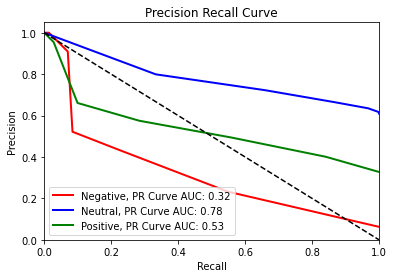

In [41]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = KNNpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

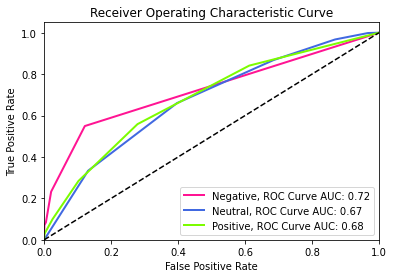

In [42]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [43]:
basescores_df.loc['6'] = pd.Series({'Model Name': 'KNNTF', 'Accuracy Score': 0.64, 'Precision Score': 0.55, 
                                    'Recall Score': 0.44, 'F1 Score': 0.46, "Cohen's Kappa Score": 0.203, 
                                    "Matthew's Correlation Coefficient": 0.228, 'Neg PRC AUC Score': 0.32, 
                                    'Neu PRC AUC Score': 0.78, 'Pos PRC AUC Score': 0.53, 'Neg ROC AUC Score': 0.72, 
                                    'Neu ROC AUC Score': 0.67, 'Pos ROC AUC Score': 0.68}) #Inputting info

## Random Forest

### Random Forest using Count Vectorizer

In [44]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier()), 
]) #Creating random forest pipeline with count vectorizer

RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', RandomForestClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.97      0.94      0.95       427
     Neutral       0.96      0.98      0.97      4148
    Positive       0.97      0.93      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.96      0.95      0.96      6802
weighted avg       0.96      0.96      0.96      6802



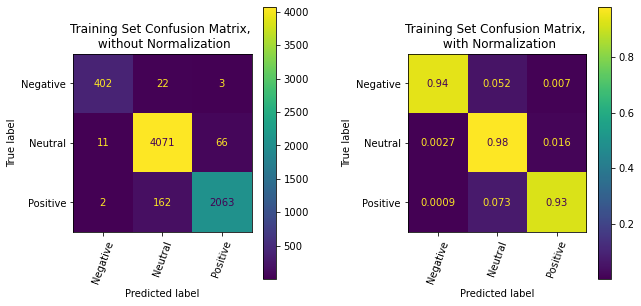

Cohen's Kappa Score for Training Set:
0.924
Matthew's Correlation Coefficient for Training Set:
0.924


In [45]:
confmat_and_classrep(RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.63      0.23      0.33       142
     Neutral       0.69      0.87      0.77      1383
    Positive       0.64      0.40      0.50       743

    accuracy                           0.68      2268
   macro avg       0.65      0.50      0.53      2268
weighted avg       0.67      0.68      0.65      2268



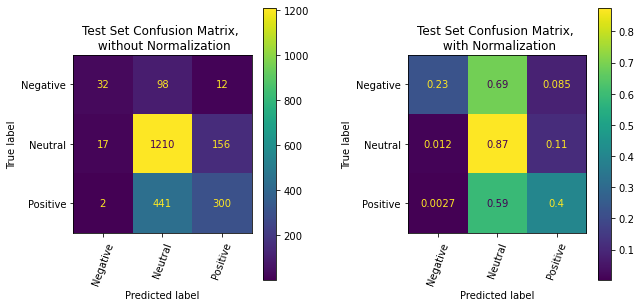

Cohen's Kappa Score for Test Set:
0.305
Matthew's Correlation Coefficient for Test Set:
0.325


In [46]:
confmat_and_classrep(RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

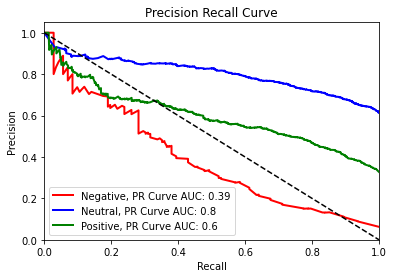

In [47]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

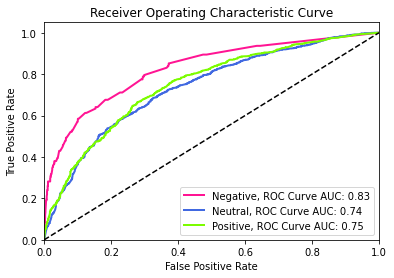

In [48]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [49]:
basescores_df.loc['7'] = pd.Series({'Model Name': 'RFCV', 'Accuracy Score': 0.68, 'Precision Score': 0.66, 
                                    'Recall Score': 0.50, 'F1 Score': 0.54, "Cohen's Kappa Score": 0.302, 
                                    "Matthew's Correlation Coefficient": 0.321, 'Neg PRC AUC Score': 0.38, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.60, 'Neg ROC AUC Score': 0.83, 
                                    'Neu ROC AUC Score': 0.74, 'Pos ROC AUC Score': 0.75}) #Inputting info

### Random Forest using TF-IDF Vectorizer

In [50]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier()), 
]) #Creating random forest pipeline with tfidf vectorizer

RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', RandomForestClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.97      0.94      0.95       427
     Neutral       0.96      0.98      0.97      4148
    Positive       0.97      0.93      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.96      0.95      0.96      6802
weighted avg       0.96      0.96      0.96      6802



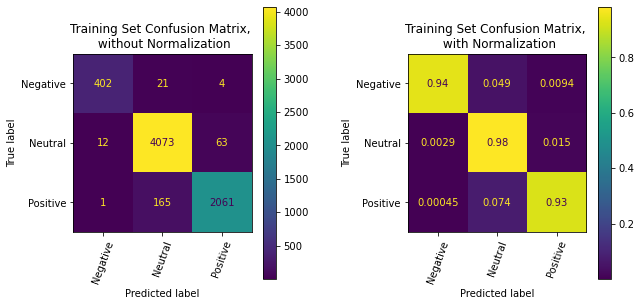

Cohen's Kappa Score for Training Set:
0.924
Matthew's Correlation Coefficient for Training Set:
0.924


In [51]:
confmat_and_classrep(RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.62      0.21      0.32       142
     Neutral       0.69      0.88      0.77      1383
    Positive       0.64      0.39      0.48       743

    accuracy                           0.68      2268
   macro avg       0.65      0.49      0.52      2268
weighted avg       0.67      0.68      0.65      2268



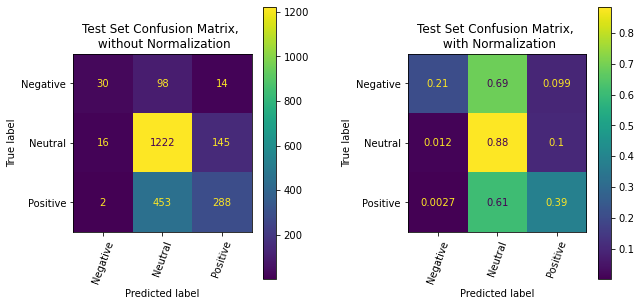

Cohen's Kappa Score for Test Set:
0.298
Matthew's Correlation Coefficient for Test Set:
0.321


In [52]:
confmat_and_classrep(RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

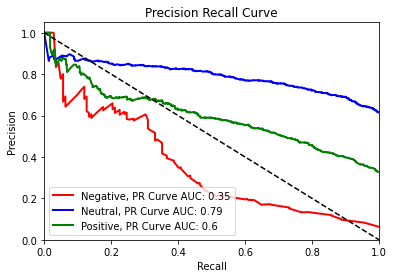

In [53]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

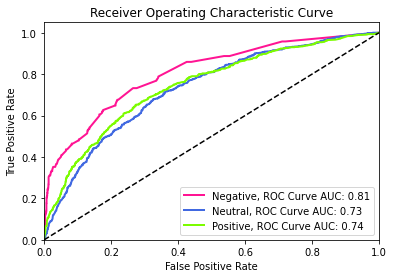

In [54]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [55]:
basescores_df.loc['8'] = pd.Series({'Model Name': 'RFTV', 'Accuracy Score': 0.68, 'Precision Score': 0.65, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.304, 
                                    "Matthew's Correlation Coefficient": 0.324, 'Neg PRC AUC Score': 0.35, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.59, 'Neg ROC AUC Score': 0.80, 
                                    'Neu ROC AUC Score': 0.73, 'Pos ROC AUC Score': 0.74}) #Inputting info

## Decision Tree

### Decision Tree using Count Vectorizer

In [56]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

DTpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', DecisionTreeClassifier()), 
]) #Creating decision tree pipeline with count vectorizer

DTpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', DecisionTreeClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96       427
     Neutral       0.95      0.99      0.97      4148
    Positive       0.99      0.90      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.95      0.96      0.96      6802
weighted avg       0.96      0.96      0.96      6802



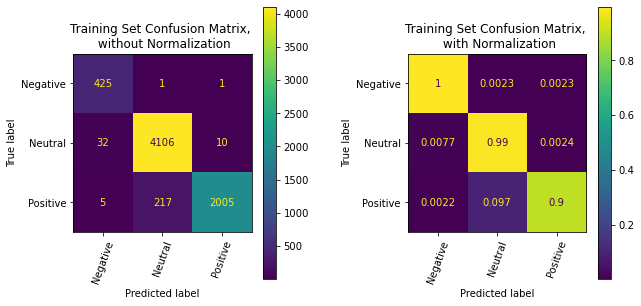

Cohen's Kappa Score for Training Set:
0.923
Matthew's Correlation Coefficient for Training Set:
0.925


In [57]:
confmat_and_classrep(DTpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training DT CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.34      0.25      0.29       142
     Neutral       0.70      0.77      0.73      1383
    Positive       0.53      0.46      0.49       743

    accuracy                           0.63      2268
   macro avg       0.52      0.49      0.50      2268
weighted avg       0.62      0.63      0.63      2268



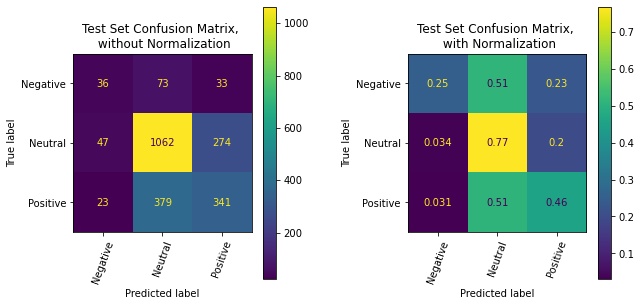

Cohen's Kappa Score for Test Set:
0.264
Matthew's Correlation Coefficient for Test Set:
0.265


In [58]:
confmat_and_classrep(DTpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test DT CV Model

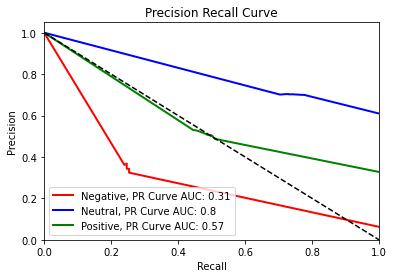

In [59]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = DTpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

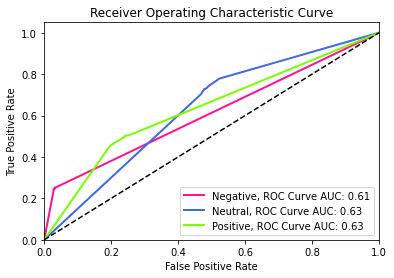

In [60]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [61]:
basescores_df.loc['9'] = pd.Series({'Model Name': 'DTCV', 'Accuracy Score': 0.65, 'Precision Score': 0.54, 
                                    'Recall Score': 0.50, 'F1 Score': 0.51, "Cohen's Kappa Score": 0.291, 
                                    "Matthew's Correlation Coefficient": 0.293, 'Neg PRC AUC Score': 0.32, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.59, 'Neg ROC AUC Score': 0.61, 
                                    'Neu ROC AUC Score': 0.64, 'Pos ROC AUC Score': 0.65}) #Inputting info

### Decision Tree using TF-IDF Vectorizer

In [62]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

DTpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', DecisionTreeClassifier()), 
]) #Creating decision tree pipeline with tfidf vectorizer

DTpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', DecisionTreeClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96       427
     Neutral       0.95      0.99      0.97      4148
    Positive       0.99      0.90      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.95      0.96      0.96      6802
weighted avg       0.96      0.96      0.96      6802



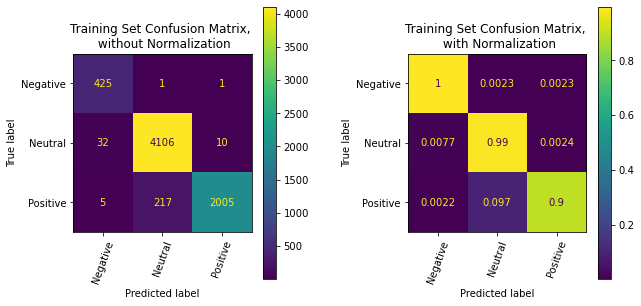

Cohen's Kappa Score for Training Set:
0.923
Matthew's Correlation Coefficient for Training Set:
0.925


In [63]:
confmat_and_classrep(DTpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training DT TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.35      0.25      0.29       142
     Neutral       0.70      0.77      0.73      1383
    Positive       0.51      0.44      0.47       743

    accuracy                           0.63      2268
   macro avg       0.52      0.48      0.50      2268
weighted avg       0.61      0.63      0.62      2268



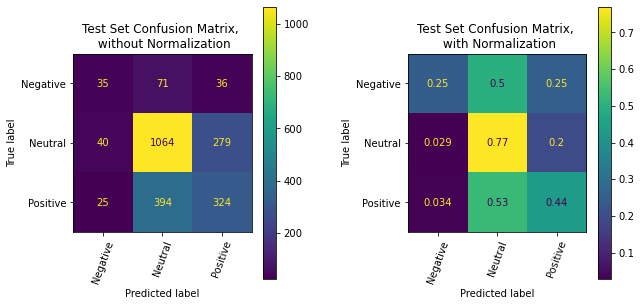

Cohen's Kappa Score for Test Set:
0.246
Matthew's Correlation Coefficient for Test Set:
0.248


In [64]:
confmat_and_classrep(DTpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test DT TF model

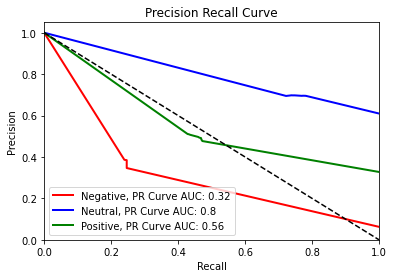

In [65]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = DTpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

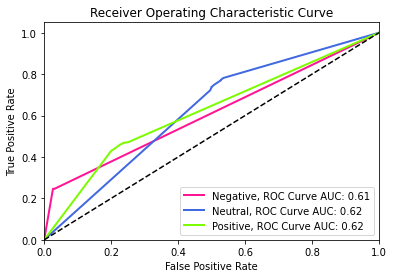

In [66]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [67]:
basescores_df.loc['10'] = pd.Series({'Model Name': 'DTTF', 'Accuracy Score': 0.63, 'Precision Score': 0.51, 
                                     'Recall Score': 0.48, 'F1 Score': 0.49, "Cohen's Kappa Score": 0.266, 
                                     "Matthew's Correlation Coefficient": 0.268, 'Neg PRC AUC Score': 0.30, 
                                     'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.57, 'Neg ROC AUC Score': 0.60, 
                                     'Neu ROC AUC Score': 0.63, 'Pos ROC AUC Score': 0.62}) #Inputting info

## AdaBoost

### AdaBoost using CountVectorizer

In [68]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

ABpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', AdaBoostClassifier()), 
]) #Creating adaboost pipeline with count vectorizer

ABpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', AdaBoostClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.57      0.22      0.31       427
     Neutral       0.65      0.94      0.77      4148
    Positive       0.59      0.16      0.25      2227

    accuracy                           0.64      6802
   macro avg       0.60      0.44      0.44      6802
weighted avg       0.62      0.64      0.57      6802



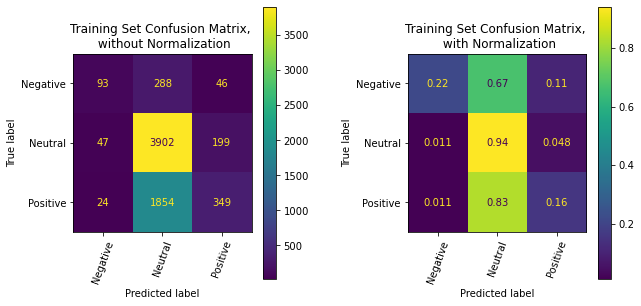

Cohen's Kappa Score for Training Set:
0.156
Matthew's Correlation Coefficient for Training Set:
0.206


In [69]:
confmat_and_classrep(ABpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training AB CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.41      0.18      0.25       142
     Neutral       0.65      0.94      0.77      1383
    Positive       0.66      0.18      0.28       743

    accuracy                           0.64      2268
   macro avg       0.57      0.43      0.43      2268
weighted avg       0.64      0.64      0.58      2268



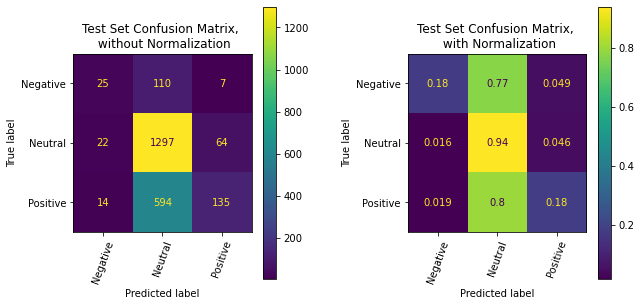

Cohen's Kappa Score for Test Set:
0.169
Matthew's Correlation Coefficient for Test Set:
0.22


In [70]:
confmat_and_classrep(ABpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test AB CV Model

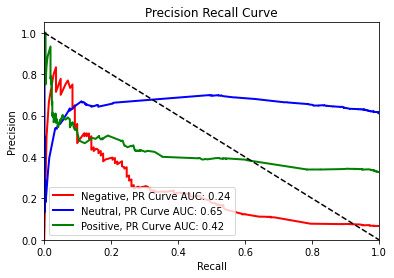

In [71]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = ABpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

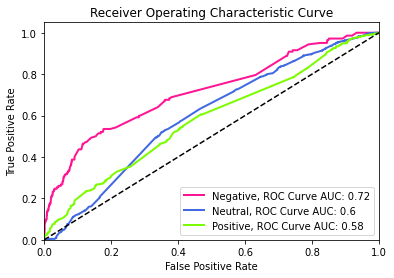

In [72]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [73]:
basescores_df.loc['11'] = pd.Series({'Model Name': 'ABCV', 'Accuracy Score': 0.64, 'Precision Score': 0.57, 
                                     'Recall Score': 0.43, 'F1 Score': 0.43, "Cohen's Kappa Score": 0.169, 
                                     "Matthew's Correlation Coefficient": 0.22, 'Neg PRC AUC Score': 0.24, 
                                     'Neu PRC AUC Score': 0.65, 'Pos PRC AUC Score': 0.42, 'Neg ROC AUC Score': 0.72, 
                                     'Neu ROC AUC Score': 0.60, 'Pos ROC AUC Score': 0.58}) #Inputting info

### AdaBoost using TF-IDF Vectorizer

In [74]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

ABpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', AdaBoostClassifier()), 
]) #Creating adaboost pipeline with tfidf vectorizer

ABpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7febfd254dc0>,
                                 tokenizer=<function passthrough at 0x7febfd254dc0>)),
                ('Classifier', AdaBoostClassifier())])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.57      0.19      0.28       427
     Neutral       0.65      0.94      0.77      4148
    Positive       0.60      0.18      0.28      2227

    accuracy                           0.64      6802
   macro avg       0.61      0.44      0.44      6802
weighted avg       0.63      0.64      0.58      6802



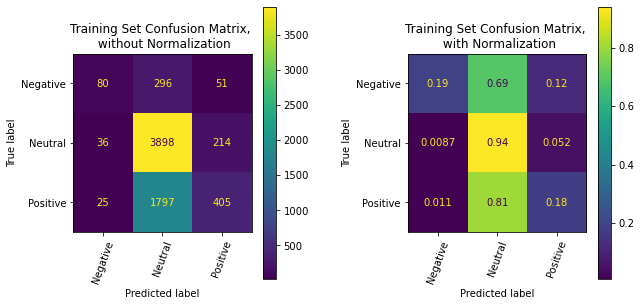

Cohen's Kappa Score for Training Set:
0.172
Matthew's Correlation Coefficient for Training Set:
0.222


In [75]:
confmat_and_classrep(ABpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training AB TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.29      0.13      0.18       142
     Neutral       0.65      0.93      0.77      1383
    Positive       0.65      0.20      0.31       743

    accuracy                           0.64      2268
   macro avg       0.53      0.42      0.42      2268
weighted avg       0.63      0.64      0.58      2268



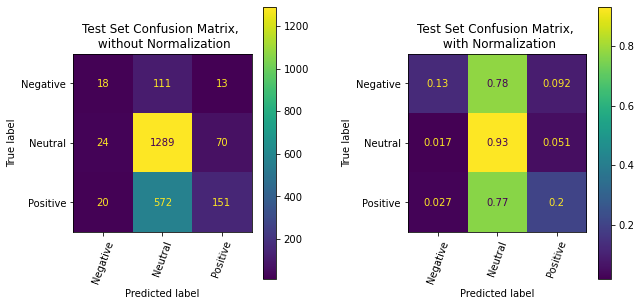

Cohen's Kappa Score for Test Set:
0.178
Matthew's Correlation Coefficient for Test Set:
0.222


In [76]:
confmat_and_classrep(ABpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test AB TF model

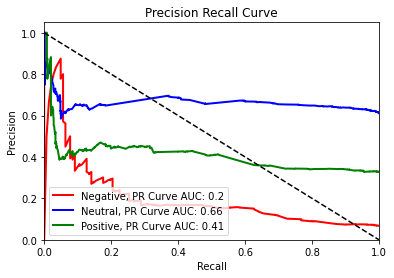

In [77]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = ABpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

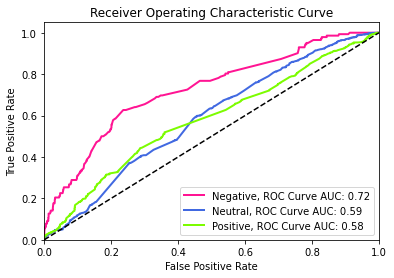

In [78]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [79]:
basescores_df.loc['12'] = pd.Series({'Model Name': 'ABTF', 'Accuracy Score': 0.64, 'Precision Score': 0.53, 
                                     'Recall Score': 0.42, 'F1 Score': 0.42, "Cohen's Kappa Score": 0.178, 
                                     "Matthew's Correlation Coefficient": 0.222, 'Neg PRC AUC Score': 0.20, 
                                     'Neu PRC AUC Score': 0.66, 'Pos PRC AUC Score': 0.41, 'Neg ROC AUC Score': 0.72, 
                                     'Neu ROC AUC Score': 0.59, 'Pos ROC AUC Score': 0.58}) #Inputting info

Alright, we've finished making 12 baseline models, 6 using the count vectorizer and 6 using tf-idf vectorizer.

# Comparing Baseline Models

We're going to look at our final baseline model scores table we created throughout this notebook and sort it by Cohen's Kappa score. We're sorting it by this metric because it is a wonderful metric for evaluating multi-class classifiers on imbalanced datasets - let's keep in mind that this dataset is extremely imbalanced. What we're looking for here is a score close to 1; generally the closer to 1 a score is, the better the classifier is.

In [80]:
basescores_df.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing baseline models

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
3,MNBCV,0.68,0.66,0.51,0.54,0.342,0.345,0.31,0.8,0.62,0.78,0.74,0.75
2,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
8,RFTV,0.68,0.65,0.49,0.52,0.304,0.324,0.35,0.79,0.59,0.8,0.73,0.74
7,RFCV,0.68,0.66,0.5,0.54,0.302,0.321,0.38,0.8,0.6,0.83,0.74,0.75
9,DTCV,0.65,0.54,0.5,0.51,0.291,0.293,0.32,0.8,0.59,0.61,0.64,0.65
10,DTTF,0.63,0.51,0.48,0.49,0.266,0.268,0.3,0.8,0.57,0.6,0.63,0.62
6,KNNTF,0.64,0.55,0.44,0.46,0.203,0.228,0.32,0.78,0.53,0.72,0.67,0.68
4,MNBTF,0.66,0.8,0.4,0.38,0.179,0.257,0.27,0.79,0.62,0.77,0.73,0.74
12,ABTF,0.64,0.53,0.42,0.42,0.178,0.222,0.2,0.66,0.41,0.72,0.59,0.58


According to our baseline model scores dataframe and using Cohen's Kappa score as our comparison metric, the top five baseline models are:

* Logistic Regression using CountVectorizer; Cohen's Kappa = 0.373
* Multinomial Naive Bayes using CountVectorizer; Cohen's Kappa = 0.342
* Logistic Regression using TF-IDF Vectorizer; Cohen's Kappa = 0.341
* Random Forest using TF-IDF Vectorizer; Cohen's Kappa = 0.304
* Random Forest using CountVectorizer; Cohen's Kappa = 0.302

It's worth noting that while these have the highest Cohen's Kappa scores out of all the baseline models, we would normally want these numbers to be closer to 1. However; we have our top performing models and now it's time to tune them to determine our final model.

In the next and final notebook, we will tune these five models in order to determine which is the best.